In [2]:
import pandas as pd
!pip3 install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install transformers requests beautifulsoup4 pandas numpy
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import sklearn.metrics as metrics
import tqdm

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.8.1+cu111 (from versions: 2.0.0)
ERROR: No matching distribution found for torch==1.8.1+cu111


In [14]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [13]:
df = pd.read_csv("reviews_final_split.csv")
df.head()

,Unnamed: 0,title,body,rating_item,rating_delivery,rating_seller,rating_marketplace,rating_total,split_ship,split_seller,split_market,split_product
0,0,"""Efficient yet lackluster shopping experience""","""Efficient yet lackluster shopping experience""...",4,2,4,2,3,"""Efficient yet lackluster shopping experience...","""Efficient yet lackluster shopping experience...","""Efficient yet lackluster shopping experience...","Overall, while there were some shortcomings,..."
1,1,"""Dependable Mobile, nothing too special.""","""Dependable Mobile, nothing too special.""I pur...",1,4,2,4,3,"""I purchased this mobile phone online and rec...","Even though the product is okay, packaging w...",The online marketplace had numerous offering...,"""Dependable Mobile, nothing too special It me..."
2,2,"""Great Purchase Experience for Mobile Phone""","""Great Purchase Experience for Mobile Phone""I ...",1,4,4,4,4,The delivery was timely and smooth,"""Great Purchase Experience for Mobile Phone""I...",I am also happy with the marketplace where ...,"The mobile phone, itself, functions well an..."
3,3,A Satisfactory Purchase,A Satisfactory PurchaseI recently acquired a m...,4,5,5,2,4,0,The seller provided excellent service and re...,The only downside to the transaction was th...,A Satisfactory PurchaseI recently acquired a ...
4,4,"""Great Mobile Phone - Disappointing Delivery a...","""Great Mobile Phone - Disappointing Delivery a...",4,1,1,4,3,"""Great Mobile Phone - Disappointing Delivery ...","""Great Mobile Phone - Disappointing Delivery ...","However, the marketplace itself was decent, ...","The phone itself is excellent, and it functi..."


In [15]:
def sentiment_score(review):
    if review == 0:
        return 0
    else:
        tokens = tokenizer.encode(review, return_tensors='pt')
        result = model(tokens)
        return int(torch.argmax(result.logits)) + 1

In [16]:
for idx, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    df.at[idx, 'rating_product_pred'] = sentiment_score(row['split_product'])
    df.at[idx, 'rating_delivery_pred'] = sentiment_score(row['split_ship'])
    df.at[idx, 'rating_seller_pred'] = sentiment_score(row['split_seller'])
    df.at[idx, 'rating_marketplace_pred'] = sentiment_score(row['split_market'])

100%|██████████| 1340/1340 [08:12<00:00,  2.72it/s]


In [17]:
df.head()

,Unnamed: 0,title,body,rating_item,rating_delivery,rating_seller,rating_marketplace,rating_total,split_ship,split_seller,split_market,split_product,rating_product_pred,rating_delivery_pred,rating_seller_pred,rating_marketplace_pred
0,0,"""Efficient yet lackluster shopping experience""","""Efficient yet lackluster shopping experience""...",4,2,4,2,3,"""Efficient yet lackluster shopping experience...","""Efficient yet lackluster shopping experience...","""Efficient yet lackluster shopping experience...","Overall, while there were some shortcomings,...",4.0,3.0,4.0,2.0
1,1,"""Dependable Mobile, nothing too special.""","""Dependable Mobile, nothing too special.""I pur...",1,4,2,4,3,"""I purchased this mobile phone online and rec...","Even though the product is okay, packaging w...",The online marketplace had numerous offering...,"""Dependable Mobile, nothing too special It me...",4.0,5.0,2.0,5.0
2,2,"""Great Purchase Experience for Mobile Phone""","""Great Purchase Experience for Mobile Phone""I ...",1,4,4,4,4,The delivery was timely and smooth,"""Great Purchase Experience for Mobile Phone""I...",I am also happy with the marketplace where ...,"The mobile phone, itself, functions well an...",4.0,5.0,5.0,5.0
3,3,A Satisfactory Purchase,A Satisfactory PurchaseI recently acquired a m...,4,5,5,2,4,0,The seller provided excellent service and re...,The only downside to the transaction was th...,A Satisfactory PurchaseI recently acquired a ...,4.0,1.0,5.0,4.0
4,4,"""Great Mobile Phone - Disappointing Delivery a...","""Great Mobile Phone - Disappointing Delivery a...",4,1,1,4,3,"""Great Mobile Phone - Disappointing Delivery ...","""Great Mobile Phone - Disappointing Delivery ...","However, the marketplace itself was decent, ...","The phone itself is excellent, and it functi...",4.0,3.0,2.0,3.0


In [18]:
df_product = df[['rating_item', 'rating_product_pred']]
df_product = df_product[df_product['rating_item'] != 0]

df_delivery = df[['rating_delivery', 'rating_delivery_pred']]
df_delivery = df_delivery[df_delivery['rating_delivery'] != 0]

df_seller = df[['rating_seller', 'rating_seller_pred']]
df_seller = df_seller[df_seller['rating_seller'] != 0]

df_marketplace = df[['rating_marketplace', 'rating_marketplace_pred']]
df_marketplace = df_marketplace[df_marketplace['rating_marketplace'] != 0]

BERT accuracy: 0.31875


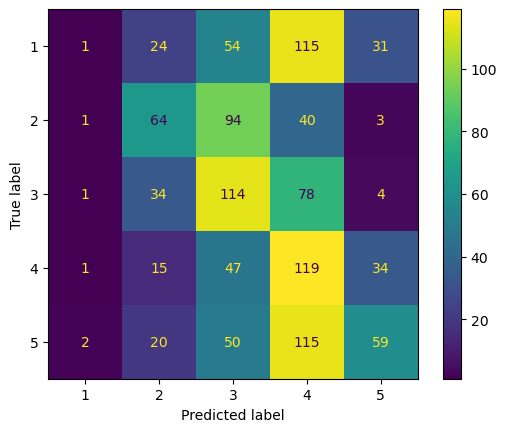

In [19]:
confusion_matrix = metrics.confusion_matrix(df_product['rating_item'], df_product['rating_product_pred'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3, 4, 5])
cm_display.plot()

print('BERT accuracy: ' + str(metrics.accuracy_score(df_product['rating_item'], df_product['rating_product_pred'])))

BERT accuracy: 0.3517857142857143


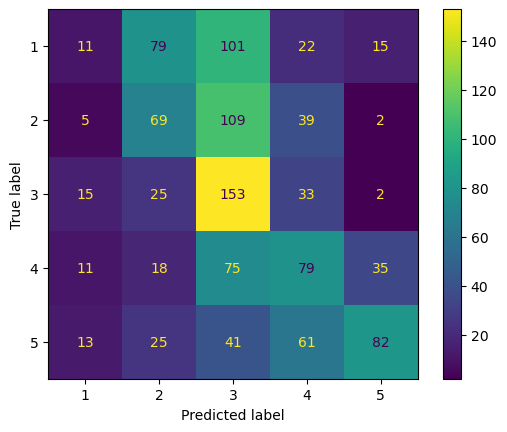

In [20]:
confusion_matrix = metrics.confusion_matrix(df_delivery['rating_delivery'], df_delivery['rating_delivery_pred'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3, 4, 5])
cm_display.plot()

print('BERT accuracy: ' + str(metrics.accuracy_score(df_delivery['rating_delivery'], df_delivery['rating_delivery_pred'])))

BERT accuracy: 0.4017857142857143


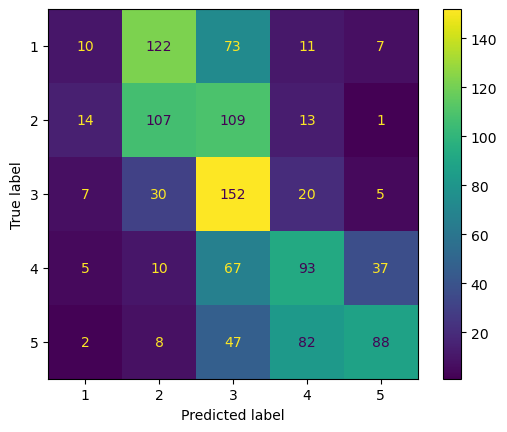

In [21]:
confusion_matrix = metrics.confusion_matrix(df_seller['rating_seller'], df_seller['rating_seller_pred'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3, 4, 5])
cm_display.plot()

print('BERT accuracy: ' + str(metrics.accuracy_score(df_seller['rating_seller'], df_seller['rating_seller_pred'])))

BERT accuracy: 0.33035714285714285


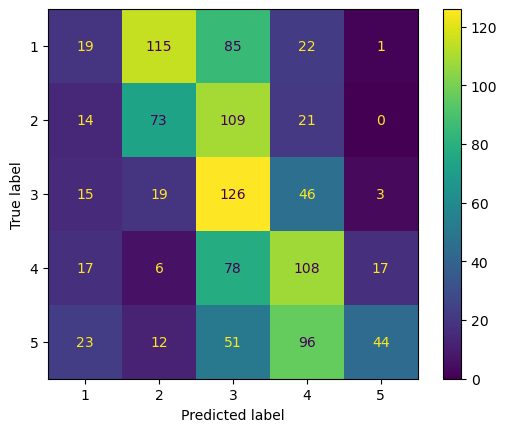

In [22]:
confusion_matrix = metrics.confusion_matrix(df_marketplace['rating_marketplace'], df_marketplace['rating_marketplace_pred'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3, 4, 5])
cm_display.plot()

print('BERT accuracy: ' + str(metrics.accuracy_score(df_marketplace['rating_marketplace'], df_marketplace['rating_marketplace_pred'])))